In [70]:
import requests
from bs4 import BeautifulSoup as bs

In [71]:
base_url = "https://www.audiotool.com/"
artists_page = "browse/users"

In [88]:

from selenium import webdriver
import time
driver = webdriver.Chrome('/tmp/chromedriver')
driver.get(base_url+artists_page)

# driver.execute_script("document.getElementById('du-toggle').classList.add('clicked')")

# driver.find_element("class name", "user")

# driver.find_element("css selector", "#main-nav > div > section > nav > label > svg").click()

# username = driver.find_element("name", "username")
# username.send_keys(info.getUsername())

# password = driver.find_element("name", "password")
# password.send_keys(info.getPassword())

# driver.find_element("css selector", "#main-nav > div > section > nav > div > section > form > div.form > input.button.fullwidth").click()

for i in range(30): # switch to 10
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
    time.sleep(3)

html = driver.page_source

C:\Users\tyler\AppData\Local\Temp\ipykernel_15768\1818974180.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/tmp/chromedriver')


In [89]:
soup = bs(html, "html.parser")

In [90]:
usernames = []
num_followers = []
num_published_tracks = []
num_favorites = []
num_albums = []
num_assets = []
num_following = []
num_wall_posts = []
time_since_joining = []
top_track_num_plays = []
top_track_num_favorites = []
top_track_genre = []

cols = [
num_followers,
num_published_tracks,
num_favorites,
num_albums,
num_following,
num_wall_posts,
time_since_joining,
top_track_num_plays,
top_track_num_favorites,
top_track_genre]

In [91]:
def getContent(element):
    return element.string

In [92]:
usernames = list(map(getContent, soup.select(".user-name-8")))

In [94]:
class ArtistError(Exception):
    pass

In [204]:
from IPython.display import clear_output
counter = 0
error_counter = 0

offset = 0

# replace below with your audiotool credentials before running
info = {"username": "YOUR-AUDIOTOOL-USERNAME",
        "password": "YOUR-AUDIOTOOL-PASSWORD"}

for j in cols: j.clear()
with requests.Session() as s:
    s.post(base_url, data=info)
    for i in soup.select(".user-name-8")[offset:]:
        artist_url = i['href']
        artist_req = s.get(base_url+artist_url)
        artist_soup = bs(artist_req.content, 'html.parser')
        try:
            if artist_req.status_code == 404: raise ArtistError(f"Page not found: {usernames[offset+counter]}")
            if "Deleted" in list(map(getContent, artist_soup.select("h1"))): raise ArtistError(f"Account deleted: {usernames[offset+counter]}")
            if len(artist_soup.select("div._if-empty")) > 0: raise ArtistError(f"No published tracks: {usernames[offset+counter]}")
            tracks = artist_soup.select("#tab-nav > ul > li.tab-tracks.selected > a > span")
            num_published_tracks.append(tracks[0].string)

            favorites = artist_soup.select("#tab-nav > ul > li.tab-favorites > a > span")
            num_favorites.append(favorites[0].string)

            albums = artist_soup.select("#tab-nav > ul > li.tab-albums > a > span")
            num_albums.append(albums[0].string)

            # currently: assets tag not being retrieved in html
            # assets = artist_soup.select("#tab-nav > ul > li.tab-assets.selected > a > span")
            # num_assets.append(assets[0].string)

            wall = artist_soup.select("#tab-nav > ul > li.tab-wall > a > span")
            num_wall_posts.append(wall[0].string)

            followers = artist_soup.select("#header-content > div > section > p > span:nth-child(1) > span")
            num_followers.append(followers[0].string)

            following = artist_soup.select("#header-content > div > section > p > span:nth-child(2) > span")
            num_following.append(following[0].string)

            registered = artist_soup.select("#header-content > div > section > p > span:nth-child(3) > span")
            time_since_joining.append(registered[0].string)
            
            # top track
            # click popular
            # click on top track
            # scrap stats from top track
            # note: top track COULD be a pinned track, which is not necessarily the user's most popular track
            # ability to hide tracks means most popular track only reflects public tracks not necessarily all tracks

            # try:
            user_popular = artist_soup.select("#body > article > div > nav > ul._filters._if-full.filter-sort > li:nth-child(2) > a")[0]['href']
            pop_req = s.get(base_url+user_popular)
            pop_soup = bs(pop_req.content, 'html.parser')
            user_top_track_url = pop_soup.select("a.entity.track._track-page")[0]['href']
            top_track_req = s.get(base_url+user_top_track_url)
            top_track_soup = bs(top_track_req.content, 'html.parser')
            
            num_favs = top_track_soup.select("span._num-favs")[0].string
            top_track_num_favorites.append(num_favs)

            play_count = top_track_soup.select("span._num-plays")[0].string
            top_track_num_plays.append(play_count)

            genre = top_track_soup.select("a._genre-name._genre-url")[0].string
            top_track_genre.append(genre)
            # except:
            #     raise ArtistError(f"Issue with top track: {usernames[counter]}")
            
            print("successfully scraped:", usernames[offset+counter])
            clear_output(wait=True)
        except ArtistError as e:
            print(e)
            error_counter += 1
            for i in cols:
                i.append(-1)
        except Exception as e:
            print(f"EXCEPTION WITH USER {usernames[offset+counter]}: {e}")
            # counter += 1
            error_counter += 1
            break
        finally:
            counter += 1

print("Tried: ", counter)
print("Success: ", counter - error_counter)
print("Errors: ", error_counter)

Account deleted: W I Z
Tried:  496
Success:  430
Errors:  66


In [205]:
import pandas as pd

In [206]:
data = dict()

cols2 = [
num_followers,
num_published_tracks,
num_favorites,
num_albums,
num_following,
num_wall_posts,
time_since_joining,
top_track_num_plays,
top_track_num_favorites,
top_track_genre]
# no top track causes issues --> put negative ones in everything

names = ["num_followers", "num_pub", "num_fav", "num_alb", "num_fol", "num_wal", "time", "top_plays", "top_favs", "top_genre"]
# print(usernames[79])
# print(num_followers[79])

for i in range(len(cols2)):
    # print(len(cols2[i]))
    data[names[i]] = cols2[i]


df = pd.DataFrame(data = data)
df = df[df.num_followers != -1]
print(df.shape[0])
df.head(5)

430


,num_followers,num_pub,num_fav,num_alb,num_fol,num_wal,time,top_plays,top_favs,top_genre
0,7596,130,1809,2,52,11825,about 12 years ago,145367,2814,Bass Music
1,4748,206,5045,11,896,24431,about 9 years ago,4049,161,Hip Hop
2,4495,427,8551,31,1358,7821,about 12 years ago,7238,192,Industrial
3,4419,310,4481,8,169,7428,about 11 years ago,52399,1693,Bass Music
4,4103,194,4760,30,605,2930,about 12 years ago,44409,308,Downtempo


In [182]:
df.to_csv("music.csv")

In [203]:
info = {"username": "audiotooldata",
        "password": "HBJJHB^%$5IOH^%$"}

test_req = requests.get(base_url+"/user/crazydruminator/")
print(test_req.status_code)

with requests.Session() as s:
        s.post(base_url, data = info)
        req = s.get(base_url+"/user/crazydruminator/", data=info)
        print(req.status_code)

404
200


In [208]:
def transform_to_int(t):
    return int(t)

def transform_time(time):
    return int(str(time).split()[1])

def transform_genre(genre):
    return str(genre)

print(df.head(10))

  num_followers num_pub num_fav num_alb num_fol num_wal                time  \
0          7596     130    1809       2      52   11825  about 12 years ago   
1          4748     206    5045      11     896   24431   about 9 years ago   
2          4495     427    8551      31    1358    7821  about 12 years ago   
3          4419     310    4481       8     169    7428  about 11 years ago   
4          4103     194    4760      30     605    2930  about 12 years ago   
5          4008       5       0      14       1     250  about 12 years ago   
6          3684     287    3182      17     278    4201  about 11 years ago   
7          3321     111    7418      30     753    5649  about 10 years ago   
8          3207     137    1401       1      49    2200  about 12 years ago   
9          3172     209   21902       1    1483    6409  about 11 years ago   

  top_plays top_favs      top_genre  
0    145367     2814     Bass Music  
1      4049      161        Hip Hop  
2      7238     

In [209]:
df['num_followers'] = df['num_followers'].apply(transform_to_int)
df['num_pub'] = df['num_pub'].apply(transform_to_int)
df['num_fav'] = df['num_fav'].apply(transform_to_int)
df['num_alb'] = df['num_alb'].apply(transform_to_int)
df['num_fol'] = df['num_fol'].apply(transform_to_int)
df['num_wal'] = df['num_wal'].apply(transform_to_int)
df['time'] = df['time'].apply(transform_time)
df['top_plays'] = df['top_plays'].apply(transform_to_int)
df['top_favs'] = df['top_favs'].apply(transform_to_int)
df['top_genre'] = df['top_genre'].apply(transform_genre)

In [213]:
df = df.reset_index()
df = df.drop(columns=['index'])

In [214]:
df.to_csv("audiotool-data-cleaned.csv")

In [225]:
# Data Visualization

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
col_names = ["Number of Tracks Published", "Number of Tracks Favorited", "Number of Albums Published", "Number Following", "Number of Posts on Wall", "Time Since Registration", "Number of Plays on Top Track", "Number of Favorites on Top Track", "Genre on Top Track"]
col_ids = ["num_followers",	"num_pub", "num_fav", "num_alb", "num_fol",	"num_wal", "time", "top_plays", "top_favs",	"top_genre"]

y = df['num_followers']
for i in range(len(col_names) - 1):
    
    x = df[col_ids[i+1]]
    a, b = np.polyfit(x, y, 1)

    plt.figure(figsize=(10,10))

    plt.scatter(x, y)
    plt.plot(x, a*x+b, color='r')

    plt.title(f"{col_names[i]} vs. Number of Followers")
    plt.xlabel(f"{col_names[i]}")
    plt.ylabel(f"Number of Followers")
    plt.show()

In [ ]:
corr = df.corr()
sns.heatmap(corr)

In [ ]:
for i in range(len(col_names) - 1):
    
    x = df[col_ids[i+1]]

    plt.hist(x, bins=50, cumulative=True)
    plt.title(f"{col_names[i]} vs. Number of Followers Histogram")

    plt.xlabel(f"{col_names[i]}")
    plt.ylabel(f"Frequency")
    plt.show()

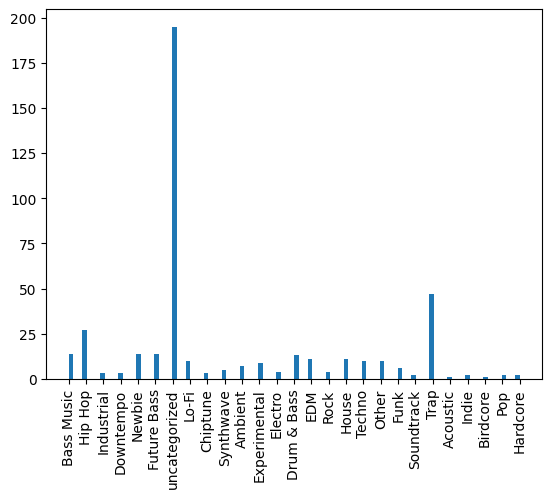

In [246]:
x = df["top_genre"]
plt.hist(x, bins=100)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: title={'center': 'Genre of Top Track'}, xlabel='Genre'>

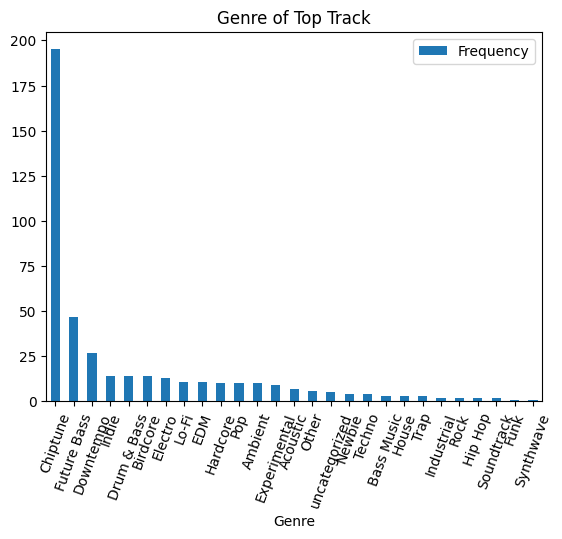

In [259]:
genre_list = list(set(df["top_genre"]))
genre_dict = {"Genre":[], "Frequency":[]}
for i in range(len(genre_list)):
    genre_dict["Genre"].append(genre_list[i])
    genre_dict["Frequency"].append(df["top_genre"].value_counts()[i])

dataFrame = pd.DataFrame(data=genre_dict)
dataFrame.plot.bar(x="Genre", y="Frequency", rot=70, title="Genre of Top Track")